---
# Objectives

1. Convert newick tree to PhyloXML format.
1. Fixes internal node names from an IQTREE tree. 
   - internal nodes by default get named the confidence (ex. "99/100")
   - this notebook instead gives them the name NODEi where i is an integer starting from 0.
   - NODE0 therefore becomes the root.
1. Convert tree to data frame.
1. Combine metadata with tree data frame.
1. Export:
   - Tree (newick, nexus, phyloxml)
   - Tree Dataframe (tsv)
   - Color mapping (tsv)
   - Lat Lon Mapping (tsv)
   - Augur JSON
   - Auspice JSON

---
# Setup

## Module Imports

In [1]:
# stats and plotting
import pandas as pd
from matplotlib import colors, gridspec
import math

# Phylogenetics
from Bio import Phylo
import treetime # Clock filter tips

# System misc

import time # Augur export
import os
import copy
from augur import utils, export_v2
import json

# Logging to file
import sys
import io

# Writing python objects to file
import dill

## Variables

In [2]:
from config import *

# Custom script variables
SCRIPT_NAME = "parse_tree"

try:
    WILDCARDS = snakemake.wildcards
    project_dir = os.getcwd()
except NameError:
    #WILDCARDS = ["all", "chromosome", "50"]
    WILDCARDS = ["all", "chromosome", "5"]
    project_dir = os.path.dirname(os.path.dirname(os.getcwd()))
    
READS_ORIGIN = WILDCARDS[0]
LOCUS_NAME = WILDCARDS[1]
MISSING_DATA = WILDCARDS[2]

NAME_COL = "Sample"

## Input File Paths

In [3]:
config_dir = os.path.join(project_dir, "results", "config")
results_dir = os.path.join(project_dir, "results")
outdir = os.path.join(results_dir, 
                      SCRIPT_NAME,
                      READS_ORIGIN, 
                      LOCUS_NAME + "_filter{}".format(MISSING_DATA),
                     )

tree_path = os.path.join(
    results_dir, 
    "iqtree", 
    READS_ORIGIN, 
    "iqtree-core_{}.filter{}_post.cf.reroot.nwk".format(LOCUS_NAME, MISSING_DATA)
)

metadata_path = os.path.join(
    results_dir,
    "metadata",
    READS_ORIGIN,
    "metadata.tsv"
)

aln_path = os.path.join(
    results_dir,
    "snippy_multi",
    READS_ORIGIN,
    "snippy-core_{}.snps.filter{}.aln".format(LOCUS_NAME, MISSING_DATA)
)

auspice_config_path = os.path.join(config_dir, "auspice_config.json")
auspice_remote_dir_path = os.path.join(project_dir, "auspice/")

print("tree_path:", tree_path)
print("metadata_path:", metadata_path)
print("aln path:", aln_path)
print("auspice_config_path:", auspice_config_path)
print("auspice_remote_dir_path:", auspice_remote_dir_path)
print("outdir:", outdir)
# Create output directory if it doesn't exist
if not os.path.exists(outdir):
    os.makedirs(outdir)

tree_path: /2/scratch/keaton/plague-phylogeography/results/iqtree/all/iqtree-core_chromosome.filter5_post.cf.reroot.nwk
metadata_path: /2/scratch/keaton/plague-phylogeography/results/metadata/all/metadata.tsv
aln path: /2/scratch/keaton/plague-phylogeography/results/snippy_multi/all/snippy-core_chromosome.snps.filter5.aln
auspice_config_path: /2/scratch/keaton/plague-phylogeography/results/config/auspice_config.json
auspice_remote_dir_path: /2/scratch/keaton/plague-phylogeography/auspice/
outdir: /2/scratch/keaton/plague-phylogeography/results/parse_tree/all/chromosome_filter5


## Import Metadata Dataframe

In [4]:
# Parse the metadata
metadata_df = pd.read_csv(metadata_path, sep='\t')

# Fix the problem with multiple forms of NA in the table
# Consolidate missing data to the NO_DATA_CHAR
metadata_df.fillna(NO_DATA_CHAR, inplace=True)

# set the metadata index
metadata_df.set_index(NAME_COL, inplace=True)

metadata_df

,Strain,Date,DateBP,Country,Province,CountryLat,CountryLon,ProvinceLat,ProvinceLon,Biovar,Branch_Major,Branch_Minor,BioSample,BioSampleComment,Branch_Number,Continent
Sample,,,,,,,,,,,,,,,,
GCA_009909635.1_ASM990963v1_genomic,9_10,1923,-98,Russia,Rostov Oblast,64.686314,97.745306,47.6222,40.7958,Medievalis,2.MED,2.MED1,SAMN13632815,KEEP: Assembly Modern,2,Europe
GCA_009669545.1_ASM966954v1_genomic,42126,2006,-15,China,Xinjiang,35.000074,104.999927,42.4805,85.4633,Antiqua,0.ANT,0.ANT1,SAMN07722925,KEEP: Assembly Modern,0,Asia
GCA_009669555.1_ASM966955v1_genomic,42123,2005,-16,China,Xinjiang,35.000074,104.999927,42.4805,85.4633,Antiqua,0.ANT,0.ANT1,SAMN07722924,KEEP: Assembly Modern,0,Asia
GCA_009669565.1_ASM966956v1_genomic,42118,2005,-16,China,Xinjiang,35.000074,104.999927,42.4805,85.4633,Antiqua,0.ANT,0.ANT1,SAMN07722923,KEEP: Assembly Modern,0,Asia
GCA_009669605.1_ASM966960v1_genomic,42117,2005,-16,China,Xinjiang,35.000074,104.999927,42.4805,85.4633,Antiqua,0.ANT,0.ANT1,SAMN07722922,KEEP: Assembly Modern,0,Asia
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
SAMEA7313243_45,Azov38,[1400:1700],[-621:-321],Russia,Rostov Oblast,64.686314,97.745306,47.6222,40.7958,Second Pandemic,1.PRE,1.PRE1,SAMEA7313243_45,KEEP: SRA Ancient Combined Record,1,Europe
SAMEA7313246_49,Gdansk8,[1400:1700],[-621:-321],Poland,Pomeranian Voivodeship,52.215933,19.134422,54.2456,18.1099,Second Pandemic,1.PRE,1.PRE1,SAMEA7313246_49,KEEP: SRA Ancient Combined Record,1,Europe
SAMEA6651390,AGU010,[1435:1477],[-586:-544],Lithuania,Vilnius County,55.350000,23.750000,54.8227,25.2495,Second Pandemic,1.PRE,1.PRE1,SAMEA6651390,KEEP: SRA Ancient,1,Europe


---
# 1. Convert tree to PhyloXML format

In [5]:
tmp_xml = os.path.join(outdir, "temp.xml")
Phylo.convert(tree_path, "newick", tmp_xml, "phyloxml")

1

---
# 2. Fix internal node names

## Read in XML tree

In [6]:
# Read in the new tree
tree = Phylo.read(tmp_xml, "phyloxml")

# Deepest nodes first
tree.ladderize(reverse=False)

## Fix node names and confidences

In [7]:
# Counter for integer node names
node_i = 0

# Iterate through the nodes in the tree
for c in tree.find_clades():
    # Check if the name has 'accidentally' become the confidence vals
    ufboot_val = NO_DATA_CHAR    
    scf_val = NO_DATA_CHAR
    # If it's a named node, parse it
    if c.name:
        name_split = c.name.split("/")
        
        # Check if the name has 'accidentally' become the confidence vals
        if len(name_split) > 1:
            # Name the internal node
            c.name = "NODE" + str(node_i)    

            # Assign confidence values     
            ufboot_val = float(name_split[0])
            scf_val = float(name_split[1])
    # If it's not a named node, give it a name
    else:
        c.name = "NODE" + str(node_i) 
        # The one and only confidence is "unknown" and if UFboot
        if len(c.confidences) > 0:
            ufboot_val = c.confidences[0].value
        c.confidences = []
        
    
    ufboot_conf = Phylo.PhyloXML.Confidence(ufboot_val, type="ufboot")
    scf_conf = Phylo.PhyloXML.Confidence(scf_val, type="scf")
    
    c.confidences.append(ufboot_conf)
    c.confidences.append(scf_conf)
        
    # Increment node counter if not a terminal
    if not c.is_terminal():
        node_i += 1

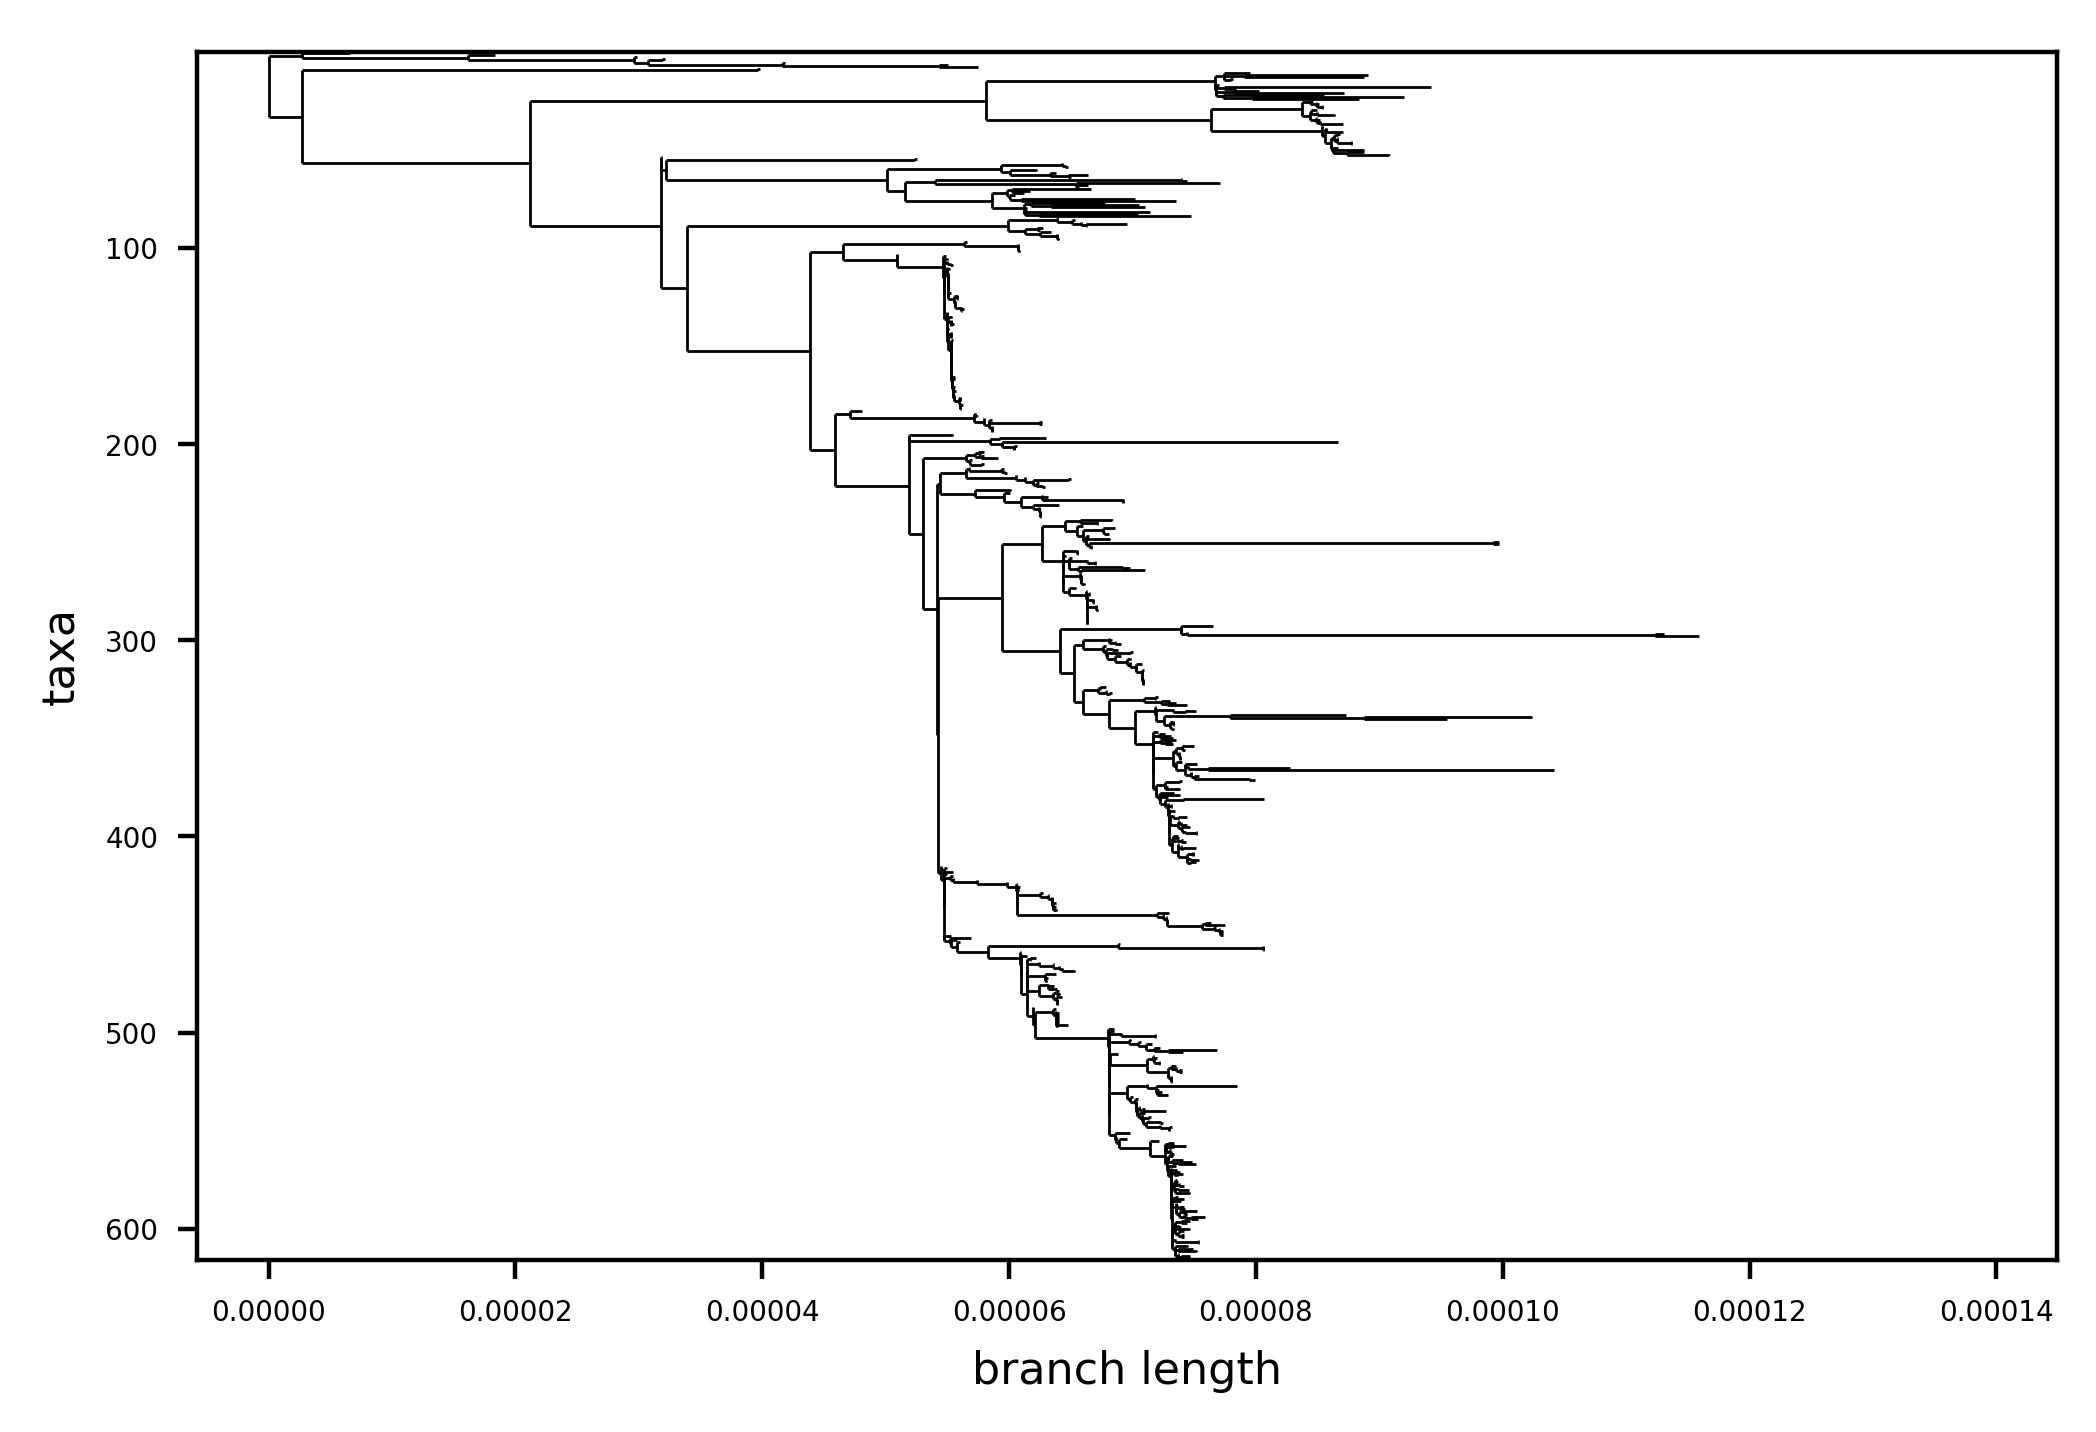

In [8]:
fig, ax1 = plt.subplots(1, dpi=400)

Phylo.draw(tree,
           axes=ax1, 
           show_confidence=False, 
           label_func = lambda x:'', 
           do_show=False,
           )

---
# 3. Convert tree to dataframe

## Initialize the tree dataframe

In [9]:
# initialize empty dataframe
tree_df = pd.DataFrame(columns = [
    "Name",
    "UFboot", 
    "sCF", 
    "Branch_Length", 
    "Branch_Support_Color", 
    "coord_x", 
    "coord_y",]
)

for c in tree.find_clades():
    if not c.branch_length: c.branch_length = 0.0
    
    node_data = {
        "Name" : c.name,
        "UFboot" : [conf.value for conf in c.confidences if conf.type=="ufboot"][0],
        "sCF" :  [conf.value for conf in c.confidences if conf.type=="scf"][0],
        "Branch_Support_Color" :  NO_DATA_CHAR,
        "Branch_Length" :  c.branch_length,
        "coord_x" :  NO_DATA_CHAR,
        "coord_y" :  NO_DATA_CHAR,
    }
    
    tree_df = tree_df.append(node_data, ignore_index=True)

# Set the index to the node name
tree_df.set_index("Name", inplace=True)

# Visualize data frame
tree_df

,UFboot,sCF,Branch_Length,Branch_Support_Color,coord_x,coord_y
Name,,,,,,
NODE0,NA,NA,0.000000e+00,NA,NA,NA
NODE1,NA,NA,2.724800e-06,NA,NA,NA
SAMEA3541827,NA,NA,3.840800e-06,NA,NA,NA
NODE2,NA,NA,1.342240e-05,NA,NA,NA
SAMEA104233046,NA,NA,2.233000e-06,NA,NA,NA
...,...,...,...,...,...,...
NODE612,NA,NA,2.345000e-07,NA,NA,NA
GCA_000268845.1_ASM26884v1_genomic,NA,NA,2.340000e-08,NA,NA,NA
NODE613,NA,NA,2.345000e-07,NA,NA,NA


## Add plotting x and y coordinates of each node

In [10]:
x_posns = get_x_positions(tree)
y_posns = get_y_positions(tree)

# Add x and y coordinates as other attributes
for c in tree.find_clades():
    # x coordinates will be of branch length units
    coord_x = [value for key,value in x_posns.items() if key.name == c.name][0]
    # y coordinates will be arbitrary, based on number of tips
    coord_y = [value for key,value in y_posns.items() if key.name == c.name][0]
    # Add data to tree dataframe
    tree_df.at[c.name, 'coord_x'] = coord_x
    tree_df.at[c.name, 'coord_y'] = coord_y    

# Visualize dataframe
tree_df

,UFboot,sCF,Branch_Length,Branch_Support_Color,coord_x,coord_y
Name,,,,,,
NODE0,NA,NA,0.000000e+00,NA,0,17.6648
NODE1,NA,NA,2.724800e-06,NA,2.7248e-06,2.07812
SAMEA3541827,NA,NA,3.840800e-06,NA,6.5656e-06,1
NODE2,NA,NA,1.342240e-05,NA,1.61472e-05,3.15625
SAMEA104233046,NA,NA,2.233000e-06,NA,1.83802e-05,2
...,...,...,...,...,...,...
NODE612,NA,NA,2.345000e-07,NA,7.37183e-05,613.75
GCA_000268845.1_ASM26884v1_genomic,NA,NA,2.340000e-08,NA,7.37417e-05,613
NODE613,NA,NA,2.345000e-07,NA,7.39528e-05,614.5


## Add branch support color

In [11]:
for c in tree.find_clades():   
    # Default Color
    branch_color = LOW_COL
    # Terminal branches will be grey
    if c.is_terminal():
        branch_color = TERM_COL
    # High support branches
    ufboot_val = tree_df["UFboot"][c.name]
    scf_val = tree_df["sCF"][c.name]
    if scf_val != NO_DATA_CHAR and ufboot_val != NO_DATA_CHAR:
        if scf_val >= SCF_THRESH and ufboot_val >= UFBOOT_THRESH:
            branch_color = HIGH_COL
    tree_df.at[c.name, "Branch_Support_Color"] = branch_color            

tree_df

,UFboot,sCF,Branch_Length,Branch_Support_Color,coord_x,coord_y
Name,,,,,,
NODE0,NA,NA,0.000000e+00,black,0,17.6648
NODE1,NA,NA,2.724800e-06,black,2.7248e-06,2.07812
SAMEA3541827,NA,NA,3.840800e-06,grey,6.5656e-06,1
NODE2,NA,NA,1.342240e-05,black,1.61472e-05,3.15625
SAMEA104233046,NA,NA,2.233000e-06,grey,1.83802e-05,2
...,...,...,...,...,...,...
NODE612,NA,NA,2.345000e-07,black,7.37183e-05,613.75
GCA_000268845.1_ASM26884v1_genomic,NA,NA,2.340000e-08,grey,7.37417e-05,613
NODE613,NA,NA,2.345000e-07,black,7.39528e-05,614.5


---
# 5. Combine metadata into tree dataframe

## Parse metadata into df

In [12]:
# Parse the metadata
metadata_df = pd.read_csv(metadata_path, sep='\t')

# Fix the problem with multiple forms of NA in the table
# Consolidate missing data to the NO_DATA_CHAR
metadata_df.fillna(NO_DATA_CHAR, inplace=True)

# set the metadata index
metadata_df.set_index(NAME_COL, inplace=True)

metadata_df

,Strain,Date,DateBP,Country,Province,CountryLat,CountryLon,ProvinceLat,ProvinceLon,Biovar,Branch_Major,Branch_Minor,BioSample,BioSampleComment,Branch_Number,Continent
Sample,,,,,,,,,,,,,,,,
GCA_009909635.1_ASM990963v1_genomic,9_10,1923,-98,Russia,Rostov Oblast,64.686314,97.745306,47.6222,40.7958,Medievalis,2.MED,2.MED1,SAMN13632815,KEEP: Assembly Modern,2,Europe
GCA_009669545.1_ASM966954v1_genomic,42126,2006,-15,China,Xinjiang,35.000074,104.999927,42.4805,85.4633,Antiqua,0.ANT,0.ANT1,SAMN07722925,KEEP: Assembly Modern,0,Asia
GCA_009669555.1_ASM966955v1_genomic,42123,2005,-16,China,Xinjiang,35.000074,104.999927,42.4805,85.4633,Antiqua,0.ANT,0.ANT1,SAMN07722924,KEEP: Assembly Modern,0,Asia
GCA_009669565.1_ASM966956v1_genomic,42118,2005,-16,China,Xinjiang,35.000074,104.999927,42.4805,85.4633,Antiqua,0.ANT,0.ANT1,SAMN07722923,KEEP: Assembly Modern,0,Asia
GCA_009669605.1_ASM966960v1_genomic,42117,2005,-16,China,Xinjiang,35.000074,104.999927,42.4805,85.4633,Antiqua,0.ANT,0.ANT1,SAMN07722922,KEEP: Assembly Modern,0,Asia
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
SAMEA7313243_45,Azov38,[1400:1700],[-621:-321],Russia,Rostov Oblast,64.686314,97.745306,47.6222,40.7958,Second Pandemic,1.PRE,1.PRE1,SAMEA7313243_45,KEEP: SRA Ancient Combined Record,1,Europe
SAMEA7313246_49,Gdansk8,[1400:1700],[-621:-321],Poland,Pomeranian Voivodeship,52.215933,19.134422,54.2456,18.1099,Second Pandemic,1.PRE,1.PRE1,SAMEA7313246_49,KEEP: SRA Ancient Combined Record,1,Europe
SAMEA6651390,AGU010,[1435:1477],[-586:-544],Lithuania,Vilnius County,55.350000,23.750000,54.8227,25.2495,Second Pandemic,1.PRE,1.PRE1,SAMEA6651390,KEEP: SRA Ancient,1,Europe


## Add metadata to tree and tree dataframe

In [13]:
# Iterate through the different metadata attributes
for attr in metadata_df.columns:
    # Initialize an empty column for the attribute
    tree_df[attr] = [NO_DATA_CHAR for row in range(0,len(tree_df))]
    # Iterate over the nodes in the tree
    for c in tree.find_clades():
        # Initialize to empty
        attr_val = NO_DATA_CHAR
        # If the node shows up in the metadata
        if c.name in metadata_df.index:
            tree_df.at[c.name, attr] = metadata_df[attr][c.name]
            attr_val = metadata_df[attr][c.name]         

tree_df

,UFboot,sCF,Branch_Length,Branch_Support_Color,coord_x,coord_y,Strain,Date,DateBP,Country,Province,CountryLat,CountryLon,ProvinceLat,ProvinceLon,Biovar,Branch_Major,Branch_Minor,BioSample,BioSampleComment,Branch_Number,Continent
Name,,,,,,,,,,,,,,,,,,,,,,
NODE0,NA,NA,0.000000e+00,black,0,17.6648,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
NODE1,NA,NA,2.724800e-06,black,2.7248e-06,2.07812,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
SAMEA3541827,NA,NA,3.840800e-06,grey,6.5656e-06,1,RISE509,[-2876:-2677],[-4897:-4698],Russia,Krasnoyarsk Krai,64.6863,97.7453,63.3234,97.098,Bronze Age,0.PRE,0.PRE2,SAMEA3541827,KEEP: SRA Ancient,0,Europe
NODE2,NA,NA,1.342240e-05,black,1.61472e-05,3.15625,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
SAMEA104233046,NA,NA,2.233000e-06,grey,1.83802e-05,2,Gyvakarai1,[-2621:-2472],[-4642:-4493],Lithuania,Panevezys County,55.35,23.75,55.9156,25.0312,Bronze Age,0.PRE,0.PRE1,SAMEA104233046,KEEP: SRA Ancient,0,Europe
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
NODE612,NA,NA,2.345000e-07,black,7.37183e-05,613.75,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
GCA_000268845.1_ASM26884v1_genomic,NA,NA,2.340000e-08,grey,7.37417e-05,613,PY-56,2010,-11,Peru,La Libertad,-6.86997,-75.0459,-8,-78.5,Orientalis,1.ORI,1.ORI1,SAMN02141479,KEEP: Assembly Modern,1,South America
NODE613,NA,NA,2.345000e-07,black,7.39528e-05,614.5,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA


## Add Reference Metadata

In [14]:
for col in tree_df.columns:
    if col in REF_META:
        tree_df.at["Reference", col] = REF_META[col]

## Make NA values consistent

In [15]:
# Fix the problem with multiple forms of NA in the table
# Consolidate missing data to the NO_DATA_CHAR
tree_df.fillna(NO_DATA_CHAR, inplace=True)

# ?. Add Metadata As Node Comments

In [16]:
for c in tree.find_clades():
    c.comment = ""
    for col in tree_df.columns:
        col_val = tree_df[col][c.name]   
        # Test for non ascii
        if type(col_val) == str and not col_val.isascii():
            col_val = col_val.encode("unicode_escape")     
        # Add comment
        if not hasattr(c, "comment") or not c.comment:
            c.comment = "&{}={}".format(col, col_val)
        else:
            c.comment += ",{}={}".format(col, col_val)

---
# 6. Export

## Objects

## Save tree and tree dataframe

In [17]:
# Dataframe
out_path_df = os.path.join(outdir, SCRIPT_NAME + ".tsv" )
out_path_pickle_df = os.path.join(outdir,  SCRIPT_NAME + ".df.obj" )

tree_df.to_csv(out_path_df, sep="\t")
with open(out_path_pickle_df,"wb") as outfile:
    dill.dump(tree_df, outfile)

# Nexus
out_path_nexus = os.path.join(outdir, SCRIPT_NAME + ".nexus" )
Phylo.write(tree, out_path_nexus, 'nexus', format_branch_length='%1.{}f'.format(BRANCH_LEN_SIG_DIG))

# Dill object
out_path_dill_tree = os.path.join(outdir,  SCRIPT_NAME + ".phylo.obj" )
with open(out_path_dill_tree,"wb") as outfile:
    dill.dump(tree, outfile)
    
# Newick (remove comments)
for c in tree.find_clades(): c.comment = None
out_path_nwk = os.path.join(outdir, SCRIPT_NAME + ".nwk" )
Phylo.write(tree, out_path_nwk, 'newick', format_branch_length='%1.{}f'.format(BRANCH_LEN_SIG_DIG))

1

## Save lat and lon

Write an output tsv that is:  
resolution   name   lat    lon

In [18]:
latlon_dict = {"Country": {}, "Province": {}}
out_path_lat_lon = os.path.join(outdir, SCRIPT_NAME + "_latlon.tsv")

# Columns in data frame will be ex: CountryLat, CountryLon
for c in tree.find_clades():
    # Iterate through each geographic level
    for level in latlon_dict:
        # Store the location name
        loc = tree_df[level][c.name]
        # If the node has location data and is new
        if loc != NO_DATA_CHAR and loc not in latlon_dict[level]:
            latlon_dict[level][loc] = {}
            latlon_dict[level][loc]["lat"] = tree_df[level + "Lat"][c.name]
            latlon_dict[level][loc]["lon"] = tree_df[level + "Lon"][c.name]

with open(out_path_lat_lon, "w") as outfile:
    for level in latlon_dict:
        for loc in latlon_dict[level]:
            outfile.write(level.lower() + "\t"
                         + loc + "\t"
                         + str(latlon_dict[level][loc]["lat"]) + "\t"
                         + str(latlon_dict[level][loc]["lon"]) + "\n"
                 )

# For clarity with auspice        
auspice_latlons_path = out_path_lat_lon         

## Save colors

Write an output tsv that is:
attribute   attribute_val   hex_color

In [19]:
out_path_colors = os.path.join(outdir, SCRIPT_NAME + "_colors.tsv")
file_colors = open(out_path_colors, "w")

hex_dict = {}

for attr in ATTRIBUTE_LIST:
    # Create the color map
    attr_key = attr.lower()
    hex_dict[attr_key] = {}
    for t in tree.get_terminals():
        attr_val = tree_df[attr][t.name]
        if attr_val not in hex_dict[attr_key] and attr_val != NO_DATA_CHAR:
            hex_dict[attr_key][attr_val] = {}
            
    # Create the custom color map (pyplot)
    cmap = plt.get_cmap(CONT_COLOR_PAL, len(hex_dict[attr_key]))
    # Convert the color map to a list of RGB values
    cmaplist = [cmap(i) for i in range(cmap.N)]
    # Convert RGB values to hex colors
    attr_hex = [colors.to_hex(col) for col in cmaplist]
    
    # Assign colors to value
    for attr_val, attr_col in zip(hex_dict[attr_key], attr_hex):
        hex_dict[attr_key][attr_val] = attr_col   

for attr_key in hex_dict:
    for attr_val in hex_dict[attr_key]:
        file_colors.write(str(attr_key) + "\t" + str(attr_val) + "\t" + str(hex_dict[attr_key][attr_val]) + "\n")

file_colors.close()        

# For clarity with auspice
auspice_colors_path = out_path_colors

## Augur JSON

  - alignment (empty)
  - input_tree (tree_path)
  - nodes (node_dict)


In [20]:
augur_dict = augur_export(
    tree_path=out_path_nwk, 
    aln_path=aln_path, 
    tree=tree, 
    tree_df=tree_df, 
    color_keyword_exclude=["color", "coord", "lat", "lon"],
    type_convert = {
        "Branch_Number" : (lambda x : str(x))
    },
)

out_path_augur_json = os.path.join(outdir, SCRIPT_NAME + "_augur.json" )
utils.write_json(data=augur_dict, file_name=out_path_augur_json, indent=JSON_INDENT)

print(augur_dict["nodes"]["Reference"])

{'ufboot': 'NA', 'scf': 'NA', 'branch_length': 1.8757999999999931e-06, 'strain': 'NA', 'date': 1992.0, 'datebp': -29.0, 'country': 'United States of America', 'province': 'Colorado', 'biovar': 'Orientalis', 'branch_major': '1.ORI', 'branch_minor': '1.ORI1', 'biosample': 'NA', 'biosamplecomment': 'KEEP: Assembly Modern Reference', 'branch_number': '1', 'continent': 'NA'}


## Auspice JSON

Manual edits of https://github.com/nextstrain/augur/blob/master/augur/export_v2.py

This can then be used for auspice via:

```
HOST="localhost" auspice view --datasetDir .
```

In [21]:
auspice_dict = auspice_export(
    tree=tree, 
    augur_json_paths=[out_path_augur_json], 
    auspice_config_path=auspice_config_path, 
    auspice_colors_path=auspice_colors_path,
    auspice_latlons_path=auspice_latlons_path, 
    )

# Write outputs - For Local Rendering
out_path_auspice_local_json = os.path.join(outdir, SCRIPT_NAME + "_auspice.json" )
utils.write_json(data=auspice_dict, file_name=out_path_auspice_local_json, indent=JSON_INDENT, include_version=False)
export_v2.validate_data_json(out_path_auspice_local_json)
print("Validation successful for local JSON.")

# Write outputs - For Remote Rendering
#out_path_auspice_remote_json = os.path.join(auspice_remote_dir_path, AUSPICE_PREFIX + SCRIPT_NAME.replace("_","-") + ".json" )
#utils.write_json(data=auspice_dict, file_name=out_path_auspice_remote_json, indent=JSON_INDENT, include_version=False)
#export_v2.validate_data_json(out_path_auspice_remote_json)
print("Validation successful for remote JSON.")

<class 'dict'>
Validating schema of '/2/scratch/keaton/plague-phylogeography/results/config/auspice_config.json'...
Validation success.


Validating produced JSON
Validating schema of '/2/scratch/keaton/plague-phylogeography/results/parse_tree/all/chromosome_filter5/parse_tree_auspice.json'...
Validating that the JSON is internally consistent...
Validation of '/2/scratch/keaton/plague-phylogeography/results/parse_tree/all/chromosome_filter5/parse_tree_auspice.json' succeeded, but there were warnings you may want to resolve.
Validation successful for local JSON.
Validation successful for remote JSON.


---
## Cleanup

In [22]:
os.remove(tmp_xml)

DEPRECATED: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.

